In [10]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)
path = './samples/'

Sacamos de la imagen dada los parámetros de transformación.
Para ello delimitamos el carril usado mediante 2 líneas laterales y 1 línea perpendicular, que marcará la frontera de la zona de trabajo.
Sacamos 4 puntos de interés, las 2 justamente donde está el capot del coche y otros 2 en la intersección de las líneas.

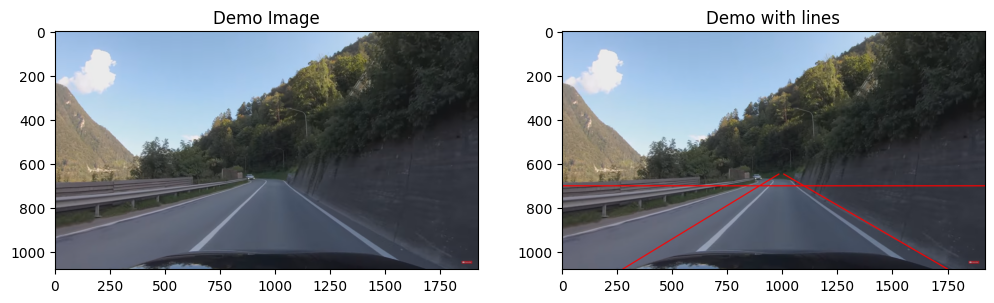

In [37]:
demo = cv2.imread(path + '01.png', -1)
demo = cv2.cvtColor(demo, cv2.COLOR_BGR2RGB)

plt.subplot(1,2,1)
demo_copy = np.copy(demo)
h,w,c = demo_copy.shape
plt.imshow(demo_copy)
plt.title('Demo Image')

pt1 = (275,h)
pt2 = (985, int (0.6*h))
cv2.line(demo,pt1,pt2,(255,0,0),3,cv2.LINE_AA)
pt3 = (1750,h)
pt4 = (1005, int (0.6*h))
cv2.line(demo,pt3,pt4,(255,0,0),3,cv2.LINE_AA)
pt5 = (0, int (0.65*h))
pt6 = (w, int (0.65*h))
cv2.line(demo,pt5,pt6,(255,0,0),3,cv2.LINE_AA)

plt.subplot(1,2,2)
plt.imshow(demo)
plt.title('Demo with lines')
plt.show()


In [87]:
# Points of the rectangle in the road
pts_src = np.array([[275, h],[1750, h],[896.25, int (0.65*h)],[1098.125, int (0.65*h)]])

# Points of a rectangle without perspective with r=1.6
pts_dst = np.array([[200, 1105], [700, 1105], [200, 300],[700, 300]])

# Calculate Homography
M, status = cv2.findHomography(pts_src, pts_dst)

Mapeamos los cuatro puntos obtenidos en un rectangulo y calculamos la matriz de transfomación.
Al aplicar la tranformación en la imágen inicial obtenemos otra, sin perspectiva alguna.

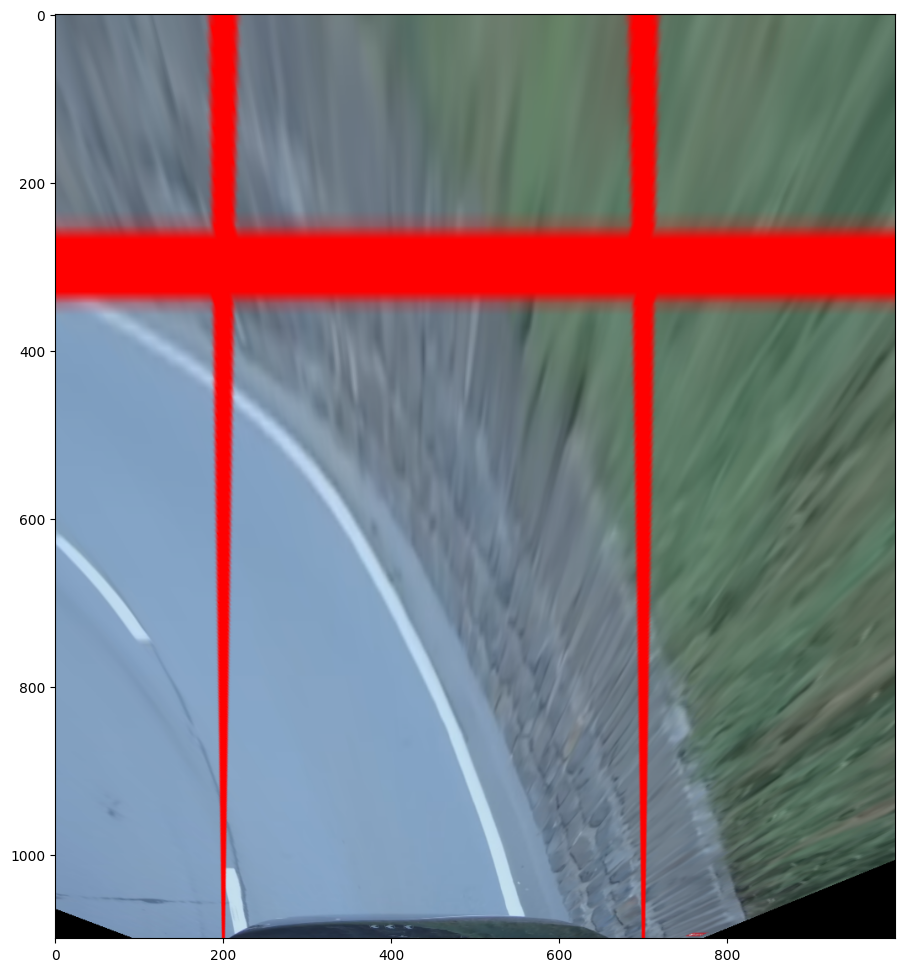

In [34]:
# Warp source image to destination based on homography
no_perspective = cv2.warpPerspective(demo, M, (1000,1100))

# Show image without perspective
plt.imshow(no_perspective)

Binarizamos la imagen resultante y obtenemos las líneas de carretera sin distorción.

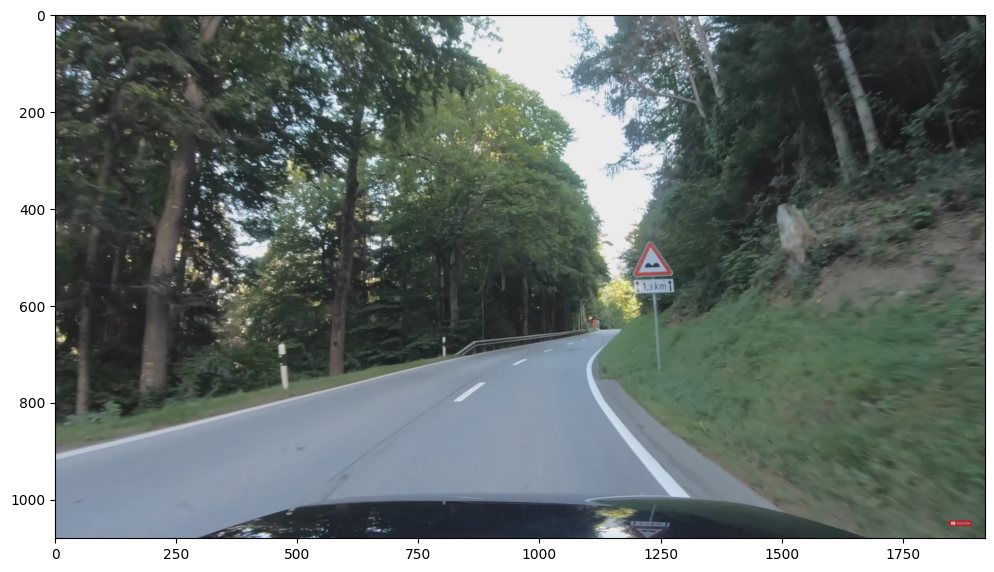

In [130]:
image_name = path + '02.png'
image = cv2.imread(image_name, -1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

(1080, 1920, 3)


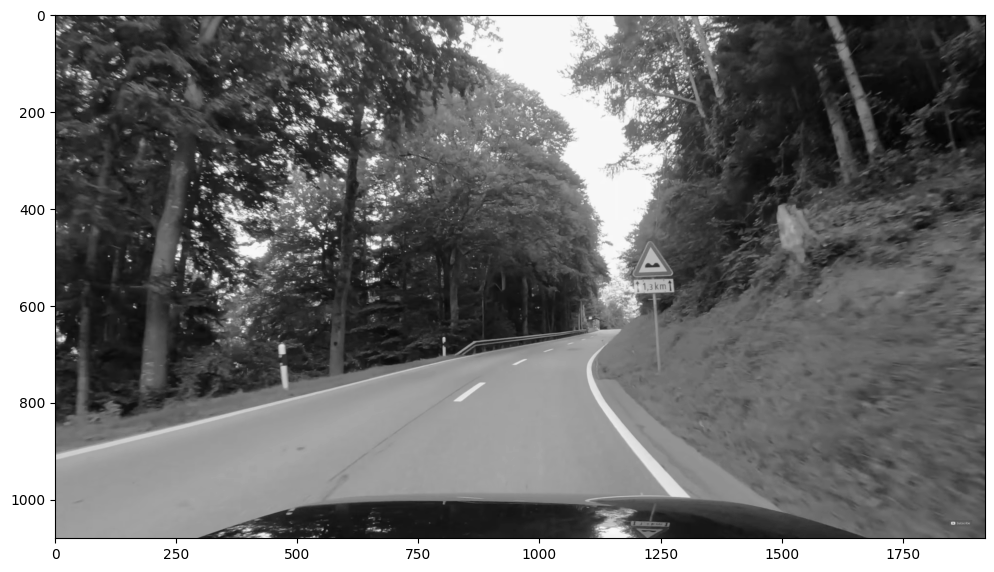

In [131]:
lab = cv2.cvtColor(image,cv2.COLOR_RGB2Lab)
h,w,c = lab.shape
print(lab.shape)
plt.imshow(lab[:,:,0], cmap='gray')

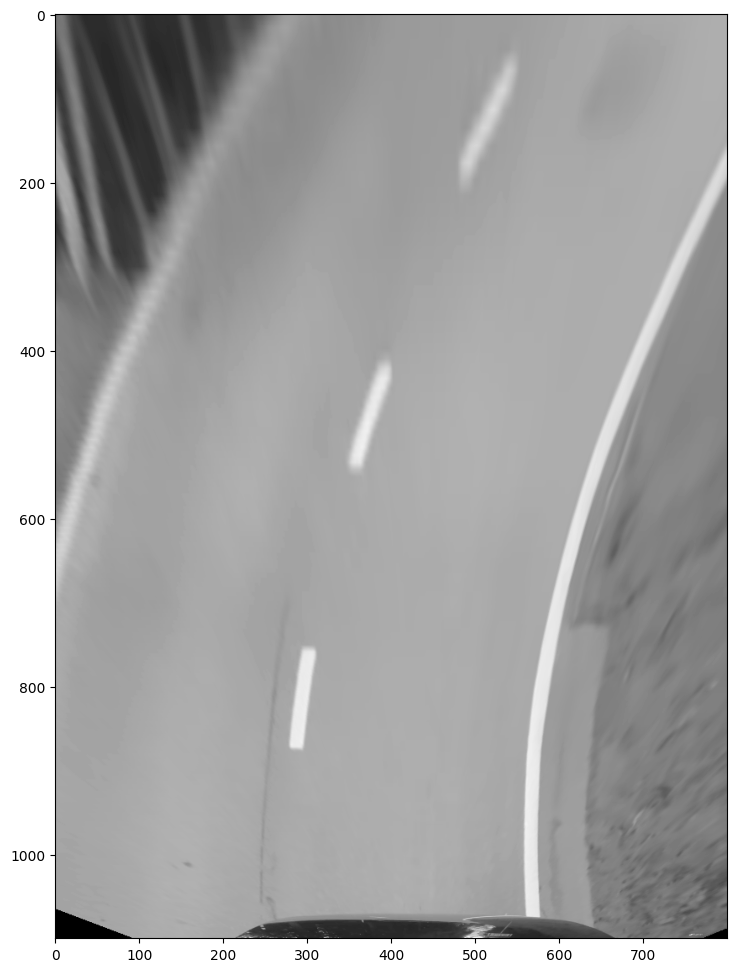

In [132]:

# Warp source image to destination based on homography
no_perspective = cv2.warpPerspective(lab[:,:,0], M, (800,1100))

# Show image without perspective
plt.imshow(no_perspective, cmap = 'gray')

# Save image
#im_out = cv2.cvtColor(no_perspective,cv2.COLOR_RGB2BGR)
#cv2.imwrite(images_path + "no_perspective.jpg",im_out);

In [133]:
#ret, binarized_no_perspective = cv2.threshold(no_perspective, 130, 255, cv2.THRESH_BINARY)

# Define horizontal and vertical kernels
#kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
#kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4

# Apply convolution
#d_h = cv2.filter2D(binarized_no_perspective,cv2.CV_16S,kernel_h) # Using ddepth=cv2.CV_16S
#d_v = cv2.filter2D(binarized_no_perspective,cv2.CV_16S,kernel_v)

# And show them!
#gradient_image = np.add(np.absolute(d_h),np.absolute(d_v))

#Normalize gradient
#norm_gradient = np.copy(binarized_no_perspective)
#norm_gradient = cv2.normalize(gradient_image, norm_gradient, 0, 255, cv2.NORM_MINMAX)

# Threshold to get edges
#threshold = 20
#ret, edges = cv2.threshold(norm_gradient, threshold, 255,cv2.THRESH_BINARY)

#plt.imshow(edges, cmap = 'gray')

In [134]:
def reference_histogram (image, verbose=True):
    from skimage.exposure import match_histograms

    ref = cv2.imread(path+'ref2.png',0)
    if (verbose):
        plt.subplot(2,2,1)
        #plt.hist(ref.ravel(),256,[0,255])
        plt.imshow(image,cmap = 'gray')
        plt.title("Reference histogram")
    matched = match_histograms(image, ref)
    if (verbose):
        plt.subplot(2,2,2)
        plt.hist(matched.ravel(),256,[0,255])
        plt.title("New image histogram")
    return matched


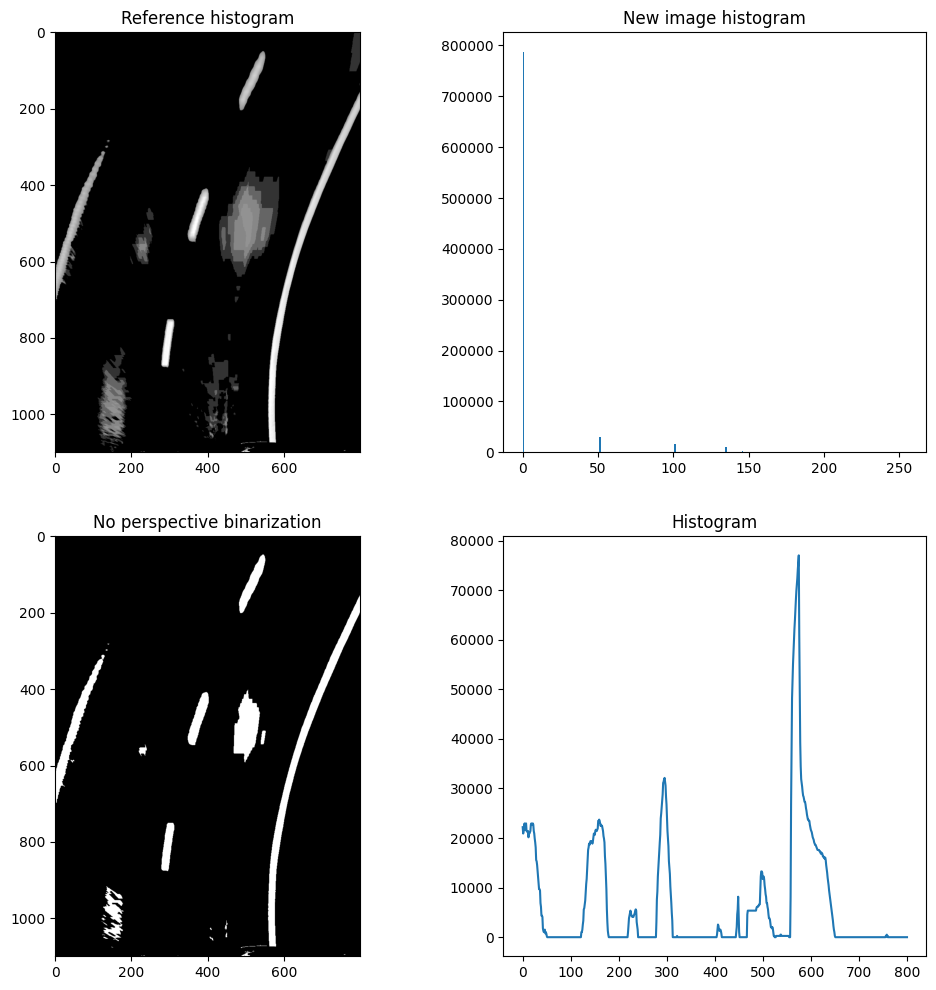

In [148]:
#Binarizamos:

#matched = match_histograms(image, reference)
no_perspective = reference_histogram(no_perspective)

ret, binarized_no_perspective = cv2.threshold(no_perspective, 130, 255, cv2.THRESH_BINARY)
#imageGaussTH = cv2.adaptiveThreshold(no_perspective, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 0)

plt.subplot(2,2,3)
plt.imshow(binarized_no_perspective,cmap ='gray')
plt.title("No perspective binarization")
#sliding window algorithm

histogram = np.sum(binarized_no_perspective[int(binarized_no_perspective.shape[0]/2):,:], axis=0)

plt.subplot(2,2,4).plot(histogram)
plt.title("Histogram")
plt.show()



In [158]:
def peaks(histogram, verbose=True):
    middle_point = histogram.shape[0]/2
    if verbose:
        print(middle_point)
    left_peak = np.max(histogram[0:int (middle_point)])
    left_index = np.where(histogram ==left_peak)[0][0]
    #left_index = histogram.index(left_peak)
    right_peak = np.max(histogram[int (middle_point):histogram.shape[0]])
    right_index = np.where(histogram == right_peak)[0][0]
    return left_index,right_index

In [159]:
## END SO FAR
peaks(histogram)

400.0


(295, 574)

In [ ]:
from scipy import signal
def nonmaxsuppts(cim, radius, thresh):
    """ Binarize and apply non-maximum suppresion.   
    
        Args:
            cim: the harris 'R' image
            radius: the aperture size of local maxima window
            thresh: the threshold value for binarization
                    
        Returns: 
            r, c: two numpy vectors being the row (r) and the column (c) of each keypoint
    """   
    
    rows, cols = np.shape(cim)
    sze = 2 * radius + 1
    mx = signal.order_filter(cim, np.ones([sze, sze]), sze ** 2 - 1)
    bordermask = np.zeros([rows, cols]);
    bordermask[radius:(rows - radius), radius:(cols - radius)] = 1
    cim = np.array(cim)
    r, c = np.where((cim == mx) & (cim > thresh) & (bordermask == 1))
    return r, c

In [ ]:
r,c = nonmaxsuppts(th, 15, thresh)
print(r.shape, ' ', c.shape)
for i in range( r.size):
    print(r[i], ' ', c[i])

NameError: name 'th' is not defined

In [ ]:
rho = 1
theta = np.pi/180
threshold = 175
lines = cv2.HoughLinesP(edges, rho, theta, threshold,
                        minLineLength=200,maxLineGap=15)
# For each line
for line in lines:
    # Draw the line in the RGB image
    x1,y1,x2,y2 = line[0]
    cv2.line(image,(x1,y1),(x2,y2),(255,0,0),2)

In [ ]:
thresh = 0.3*harris.max()
_,th = cv2.threshold(harris, thresh, 255, cv2.THRESH_BINARY)
plt.imshow(th,cmap='gray')